In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import LeaveOneOut,cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn.kernel_approximation import PolynomialCountSketch
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.decomposition import PCA
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import influence_plot
from sklearn.preprocessing import StandardScaler

In [2]:
#generate and filter the data
data = pd.read_csv('new_data.csv')
data['Sex'] = data['Sex'].replace('M',1)
data['Sex'] = data['Sex'].replace('F',0)
data['Side'] = data['Side'].replace('L',0)
data['Side'] = data['Side'].replace('R',1)
X = data[['Age','Sex','BMI','GX AT VO2 (mL/kg/min)','GX AT VE/VCO2','GX VO2 Max VO2 (mL/kg/min)','GX VO2 Max VO2/Pred (%)','GX VO2 Max VO2/HR (mL/beat)','GX Predicted VO2/HR (mL/beat)','GX Work Max Work (Watts)','GX Predicted Work (Watts)','PF Pre FEV1/FVC (%)','PF Pre FEV1 (L)','Side','pred mort','LOS']]
X = X.dropna(axis=0)

In [3]:
X2 = X[['Age','Sex','BMI','GX AT VO2 (mL/kg/min)','GX AT VE/VCO2','GX VO2 Max VO2 (mL/kg/min)','GX VO2 Max VO2/Pred (%)','GX VO2 Max VO2/HR (mL/beat)','GX Predicted VO2/HR (mL/beat)','GX Work Max Work (Watts)','GX Predicted Work (Watts)','PF Pre FEV1/FVC (%)','PF Pre FEV1 (L)','Side','pred mort','LOS']]
X2=X2.rename(columns= {"GX VO2 Max VO2 (mL/kg/min)":'G2',"GX AT VO2 (mL/kg/min)" : "G0", "GX AT VE/VCO2" : "G1",
                        'GX VO2 Max VO2/Pred (%)' : 'G3','GX VO2 Max VO2/HR (mL/beat)':'G4','GX Predicted VO2/HR (mL/beat)':'G5','GX Work Max Work (Watts)':'G6','GX Predicted Work (Watts)':'G7','PF Pre FEV1/FVC (%)':'G8','PF Pre FEV1 (L)':'G9', 'pred mort' : 'predmort'})
X2 = X2.drop(X2[(X2['G8'] == 0.0)|(X2['G9'] == 0.0)].index)
X2.shape

(186, 16)

In [4]:
X_value = X2[['Age','Sex','BMI','G0','G1','G2','G3','G4','G5','G6','G7','G8','G9','Side','predmort']]
y_value = X2[['LOS']]

In [94]:
X_standard = StandardScaler().fit_transform(X_value)
pca = PCA(n_components=15)
principla = pca.fit_transform(X_standard)
pca.explained_variance_ratio_

array([0.38912813, 0.16896537, 0.09883343, 0.09243895, 0.0697245 ,
       0.04929008, 0.0410426 , 0.02674269, 0.0184243 , 0.01703773,
       0.01117723, 0.00909672, 0.00583964, 0.00177818, 0.00048045])

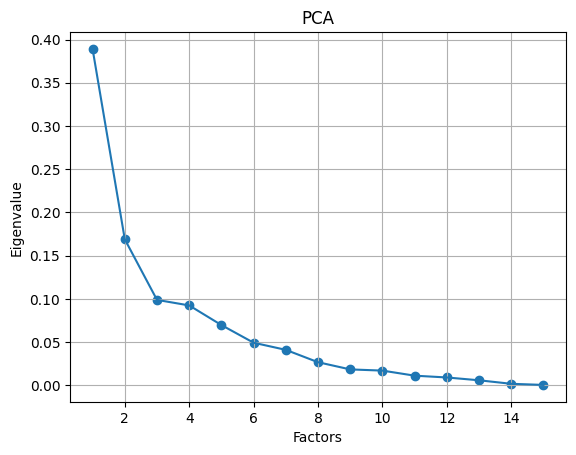

In [95]:
importance = pca.explained_variance_ratio_
plt.scatter(range(1,16),importance)
plt.plot(range(1,16),importance)
plt.title('PCA')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [116]:
def regression_model_withPCA(model,X,y):
    lg = model
    y = np.array(y)
    X1 = np.array(X)
    mean_ab_error = []
    mean_sq_error = []
    median_error = []
    pred = []
    y_true = []
    loo = LeaveOneOut()
    pca = PCA(0.95)
    
    for train_index, test_index in loo.split(X1):
        X_train, X_test = X1[train_index], X1[test_index]
        y_train, y_test = y[train_index], y[test_index]
        y_test = np.array(y_test)
        y_train = np.array(y_train)
        
        scalar = StandardScaler()
        scalar.fit(X_train)
        
        X_train = scalar.transform(X_train)
        X_test = scalar.transform(X_test)


        pca.fit(X_train)

        X_train = pca.transform(X_train)
        X_test = pca.transform(X_test)

        lg.fit(X_train,y_train)

        predict_data = lg.predict(X_test)
        pred.append(predict_data)
        y_true.append(y_test)

        mean_ab_error.append(mean_absolute_error(y_test,predict_data))
        mean_sq_error.append(mean_squared_error(y_test,predict_data))
        median_error.append(median_absolute_error(y_test,predict_data))

    print("Leave one out validation")
    MAE = np.sum(np.array(mean_ab_error)) / len(mean_ab_error)
    print(f"MAE of the model is {MAE}")
    MSE = np.sum(np.array(mean_sq_error)) / len(mean_sq_error)
    print(f"MSE of the model is {MSE}")
    Median = np.median(np.array(median_error))
    print(f"Median absolute error of the model is {Median}")
    SD = np.std(pred)
    print(f"Standard Deviation of the model is {SD}")
    # r2 = r2_score(y_true,pred)
    # print(f"R2 score of the model is {r2}")
    y_new = np.array(y_true).reshape(-1)
    pred_new = np.array(pred).reshape(-1)
    r2 = r2_score(y_new,pred_new)
    print(f"R2 score of the model is {r2}")
    return y_new,pred_new

In [111]:
def regression_model(model,X,y):
    lg = model
    y = np.array(y)
    X1 = np.array(X)
    mean_ab_error = []
    mean_sq_error = []
    median_error = []
    pred = []
    y_true = []
    loo = LeaveOneOut()
    
    for train_index, test_index in loo.split(X1):
        X_train, X_test = X1[train_index], X1[test_index]
        y_train, y_test = y[train_index], y[test_index]
        y_test = np.array(y_test)
        y_train = np.array(y_train)

        lg.fit(X_train,y_train)

        predict_data = lg.predict(X_test)
        pred.append(predict_data)
        y_true.append(y_test)

        mean_ab_error.append(mean_absolute_error(y_test,predict_data))
        mean_sq_error.append(mean_squared_error(y_test,predict_data))
        median_error.append(median_absolute_error(y_test,predict_data))

    MAE = np.sum(np.array(mean_ab_error)) / len(mean_ab_error)
    MSE = np.sum(np.array(mean_sq_error)) / len(mean_sq_error)
    Median = np.median(np.array(median_error))
    SD = np.std(pred)
    y_new = np.array(y_true).reshape(-1)
    pred_new = np.array(pred).reshape(-1)
    r2 = r2_score(y_new,pred_new)
    
    plot_graph(MAE,MSE,Median,sd,r2)

In [115]:
def plot_graph(MAE,MSE,Median,sd,r2):
    x_data = ('MAE','MSE','Median AE','s.d','R2 score')
    y_data = [MAE,MSE,Median,sd,r2]
    color = 'coral'
    bar = plt.bar(x_data,y_data,0.3,color=color,edgecolor ='grey')
    plt.bar_label(bar, label_type='edge')
    plt.show()
    plt.close()

Leave one out validation
MAE of the model is 4.243478857687632
MSE of the model is 42.89014797010418
Median absolute error of the model is 3.0588176993569633
Standard Deviation of the model is 1.9017921724632878
R2 score of the model is -0.01129080591232512


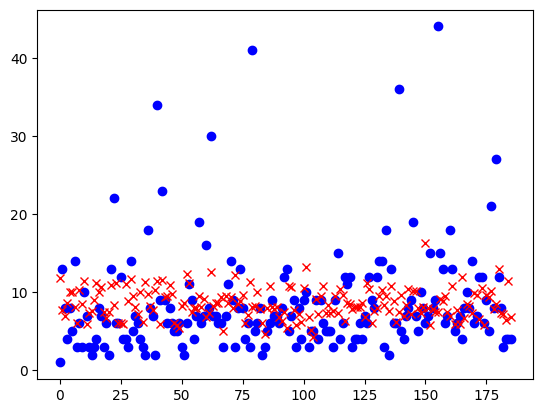

In [119]:
model = LinearRegression()
truev, predv = regression_model_withPCA(model,X_value,y_value)
plt.plot(truev,'bo')
plt.plot(predv,'rx')

(186,)

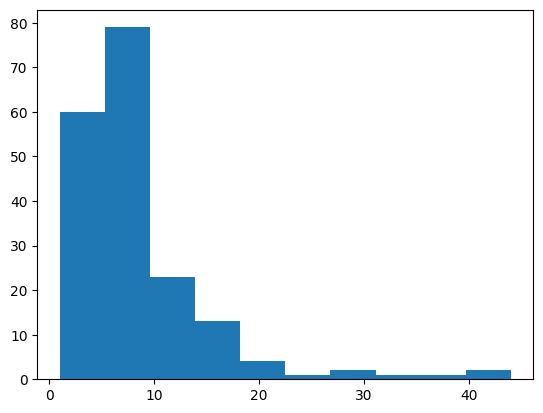

In [127]:
#看分段表现
plt.hist(truev)
truev.shape

(186,)

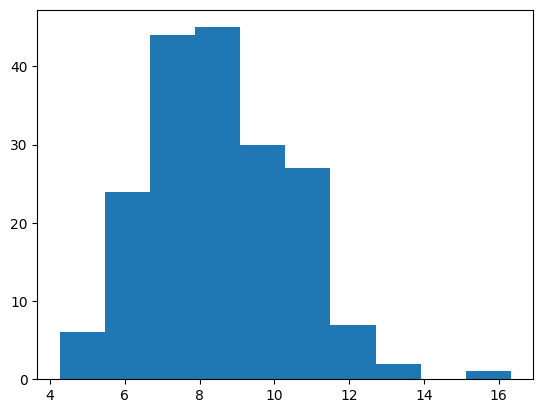

In [130]:
plt.hist(predv)
predv.shape

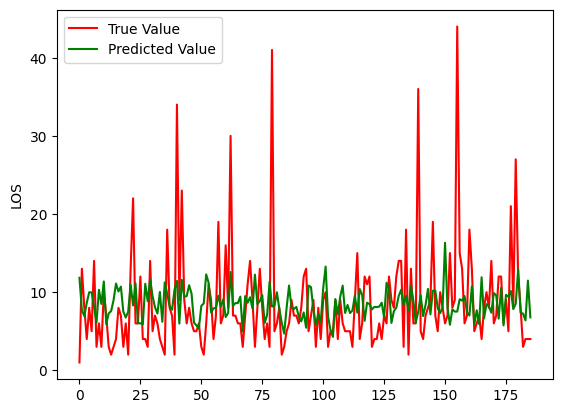

In [239]:
plt.plot(truev,'r-', label='True Value')
plt.plot(predv,'g-', label='Predicted Value')
plt.legend()
plt.ylabel("LOS")
plt.show()

In [133]:
d1 = truev[0:50]
d2 = predv[0:50]

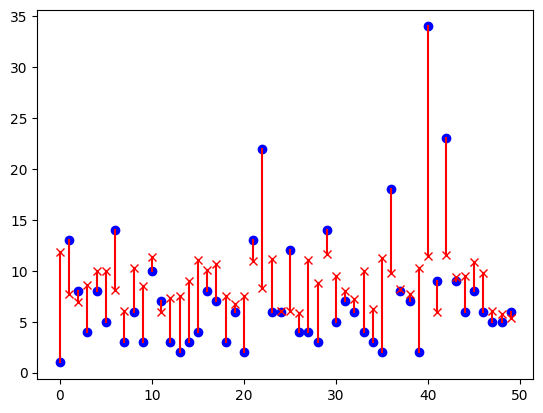

In [138]:
plt.plot(d1,'bo')
plt.plot(d2,'rx')
for i in range(50):
    plt.plot((i, i), (d1[i],d2[i]), 'r-')

In [185]:
arr = []
for i in range(186):
    arr.append([truev[i],predv[i]])

In [193]:
arr = np.array(arr)
arr.shape

(186, 2)

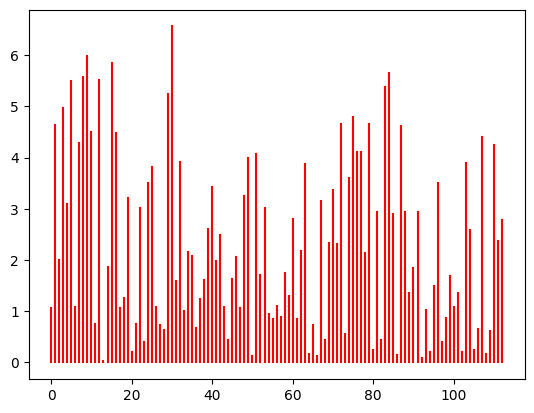

In [182]:
for i in range(113):
    plt.plot((i,i),(0,abs(arr[i,0]-arr[i,1])),'r-')

In [228]:
arr1 = arr[arr[:,0] >20]
arr2 = arr[arr[:,0] <20]
arr1

array([[22.        ,  8.29836539],
       [34.        , 11.43895921],
       [23.        , 11.5727117 ],
       [30.        , 12.57786143],
       [41.        ,  8.14841257],
       [36.        ,  7.50967263],
       [44.        ,  7.51888887],
       [21.        , 10.14965803],
       [27.        ,  8.51835257]])

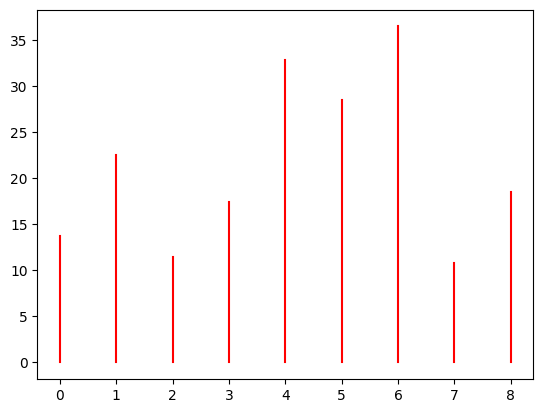

In [240]:
loss1 = 0
for i in range(len(arr1)):
    plt.plot((i,i),(0,abs(arr1[i,0]-arr1[i,1])),'r-')
    loss1 += abs(arr1[i,0]-arr1[i,1])
loss1 = loss1 / len(arr1)

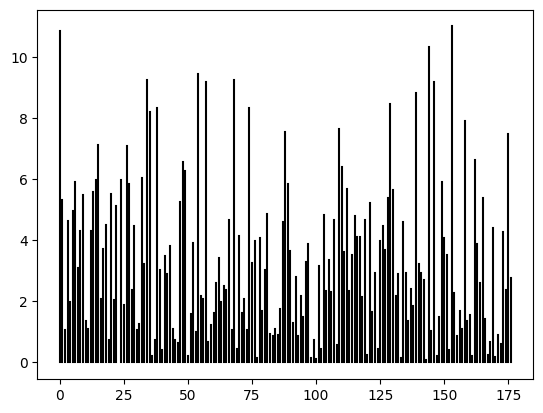

In [247]:
loss2 = 0
for i in range(len(arr2)):
    plt.plot((i,i),(0,abs(arr2[i,0]-arr2[i,1])),'k-')
    loss2 += abs(arr2[i,0]-arr2[i,1])
loss2 = loss2 / len(arr2)

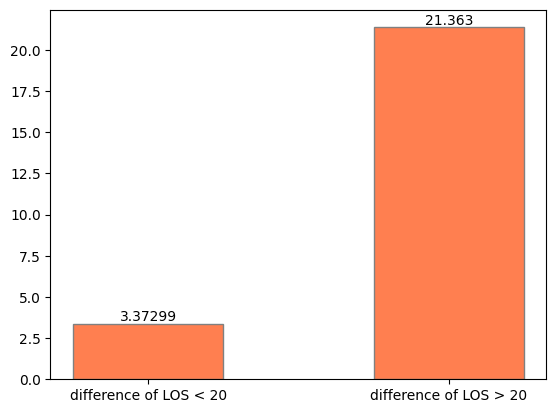

In [251]:
x_data = ('difference of LOS < 20','difference of LOS > 20',)
y_data = [loss2,loss1]
color = 'coral'
bar = plt.bar(x_data,y_data,0.5,color=color,edgecolor ='grey')
plt.bar_label(bar, label_type='edge')
plt.show()
plt.close()